# Sentiment analysis

${Authors}$: Rémi KHOURY - Morgane BROSSARD

This notebook is based on the sentiment140 dataset (url available here : https://www.kaggle.com/datasets/kazanova/sentiment140/code?datasetId=2477&sortBy=commentCount)

In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

File ‘data/training.1600000.processed.noemoticon.csv.zip’ already there; not retrieving.

Archive:  data/training.1600000.processed.noemoticon.csv.zip


## 0. Set-up

In [2]:
!pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# necessary import
import pandas as pd
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

from collections import Counter
from nltk.tokenize import word_tokenize

In [4]:
# Dataset columns and encoding
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# Load dataset
sentiment140_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
sentiment140_df.head(5)

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [5]:
# crop the dataset to work on the code (TO BE REMOVED)
sentiment140_df = sentiment140_df.groupby('target').sample(n=100000, random_state=42)
print(sentiment140_df['target'].value_counts())
sentiment140_df.to_csv('1000_tweets_sympas.csv', index=False)

target
0    100000
4    100000
Name: count, dtype: int64


Explore the dataset :


In [6]:
decode_map = {0: -1, 2: 0, 4: 1}
sentiment140_df['target'] = sentiment140_df['target'].map(decode_map)

# Warning : hard to compute
# text = " ".join(sentiment140_df['text'])
# tokens = word_tokenize(text)
# tokens = [word.lower() for word in tokens if word.isalnum()]

print(f'Number of rows: {len(sentiment140_df)}')
print('Target values: ', sentiment140_df['target'].unique())
# print(f'Vocabulary size: {len(set(tokens))}')

Number of rows: 200000
Target values:  [-1  1]


Text(0.5, 1.0, 'Dataset labels distribuition')

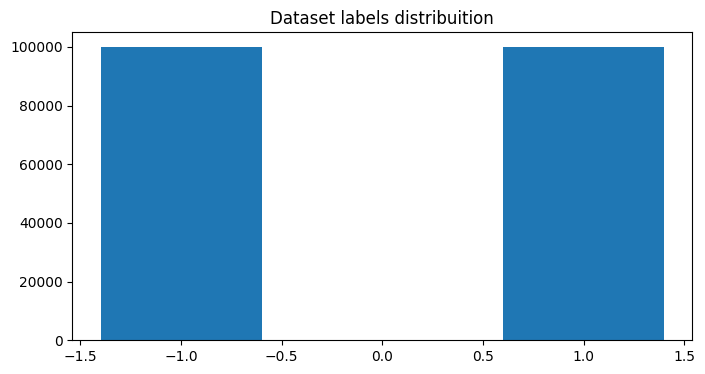

In [7]:
target_cnt = Counter(sentiment140_df.target)

plt.figure(figsize=(8, 4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## 1. Preprocessing

In [8]:
# necessary imports
import re
import itertools
import sklearn
from nltk.corpus import stopwords

In [9]:
# Pre-processing functions
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase
        - Removing all that is not a number or a letter
        - Removing all urls
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """
    text = text.lower()
    REMOVE_PUNCT = re.compile(r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+")
    text = REMOVE_PUNCT.sub(" ", text)
    return word_tokenize(text, language='english')

sentiment140_df['sentence'] = sentiment140_df['text'].apply(clean_and_tokenize)
sentiment140_df.head(5)

target         ids                          date      flag  \
212188      -1  1974671194  Sat May 30 13:36:31 PDT 2009  NO_QUERY   
299036      -1  1997882236  Mon Jun 01 17:37:11 PDT 2009  NO_QUERY   
475978      -1  2177756662  Mon Jun 15 06:39:05 PDT 2009  NO_QUERY   
588988      -1  2216838047  Wed Jun 17 20:02:12 PDT 2009  NO_QUERY   
138859      -1  1880666283  Fri May 22 02:03:31 PDT 2009  NO_QUERY   

                  user                                               text  \
212188         simba98  @xnausikaax oh no! where did u order from? tha...   
299036          Seve76  A great hard training weekend is over.  a coup...   
475978  x__claireyy__x  Right, off to work  Only 5 hours to go until I...   
588988          Balasi                    I am craving for japanese food    
138859    djrickdawson  Jean Michel Jarre concert tomorrow  gotta work...   

                                                 sentence  
212188  [oh, no, where, did, u, order, from, that, s, ...  
299036  [a, great, hard, training, weekend, is, over, ...  
475978  [right, off, to, work, only, 5, hours, to, go,...  
588988              [i, am, craving, for, japanese, food]  
138859  [jean, michel, jarre, concert, tomorrow, got, ...

Create a vocabulary

In [10]:
def get_vocabulary(corpus, voc_threshold=0):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary (0 means no limit !)
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
    """

    word_counts = {}
    for sent in corpus:
      for word in sent:
        if (word not in word_counts):
          word_counts[word] = 0
        word_counts[word] += 1
    words = sorted(word_counts.keys(), key=word_counts.get, reverse=True)
    if voc_threshold > 0:
        words = words[:voc_threshold] + ['UNK']
    vocabulary = {words[i] : i for i in range(len(words))}
    return vocabulary, {word: word_counts.get(word, 0) for word in vocabulary}

sentences = sentiment140_df['sentence'].tolist()
vocabulary, word_counts = get_vocabulary(sentences)

print(vocabulary)
print(word_counts)

{'i': 0, 'to': 1, 'the': 2, 'a': 3, 'my': 4, 'it': 5, 'and': 6, 'you': 7, 'is': 8, 'for': 9, 'in': 10, 's': 11, 'of': 12, 't': 13, 'on': 14, 'that': 15, 'me': 16, 'so': 17, 'have': 18, 'm': 19, 'but': 20, 'just': 21, 'with': 22, 'at': 23, 'be': 24, 'not': 25, 'was': 26, 'can': 27, 'this': 28, 'now': 29, 'good': 30, 'up': 31, 'day': 32, 'all': 33, 'out': 34, 'get': 35, 'like': 36, 'are': 37, 'no': 38, 'go': 39, 'quot': 40, 'got': 41, 'today': 42, 'work': 43, 'do': 44, 'your': 45, 'too': 46, 'love': 47, 'going': 48, 'we': 49, 'what': 50, 'lol': 51, 'time': 52, 'from': 53, 'u': 54, 'back': 55, 'one': 56, 'will': 57, 'know': 58, 'don': 59, 'about': 60, 'really': 61, 'im': 62, 'amp': 63, 'am': 64, 'had': 65, 'see': 66, 'some': 67, 'its': 68, 'there': 69, 'if': 70, '2': 71, 'they': 72, 'how': 73, 'night': 74, 'want': 75, 'still': 76, 'new': 77, 'well': 78, 'think': 79, 'na': 80, 'll': 81, 'home': 82, 'when': 83, 'thanks': 84, 'he': 85, 'as': 86, 'more': 87, 'oh': 88, 'here': 89, 'off': 90, '

89544


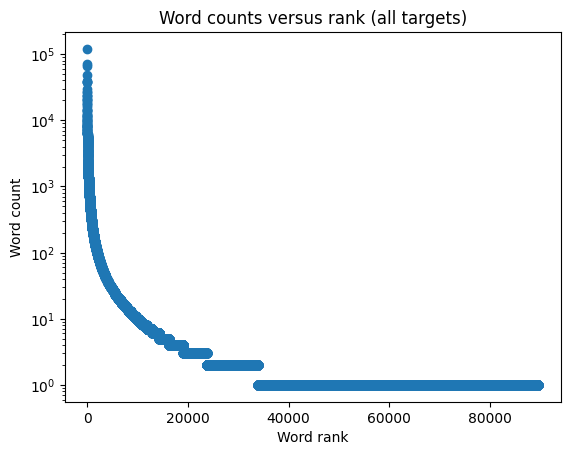

In [11]:
print(len(word_counts))

# Look at the frequency/rank plot
plt.title('Word counts versus rank (all targets)')
plt.scatter(range(len(word_counts)), list(word_counts.values()))
plt.yscale('log')
plt.xlabel('Word rank')
plt.ylabel('Word count')
plt.show()

In [12]:
# Where target == -1
sentences = sentiment140_df[sentiment140_df['target'] == -1]['sentence'].tolist()
vocabulary, word_counts = get_vocabulary(sentences)
word_rank = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(5)
print(f'Word rank where target == -1')
print(f'{word_rank} \n')

# Where target == 1
sentences = sentiment140_df[sentiment140_df['target'] == 1]['sentence'].tolist()
vocabulary, word_counts = get_vocabulary(sentences)
word_rank = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(5)
print(f'Word rank where target == 1')
print(f'{word_rank} \n')

# All targets
sentences = sentiment140_df['sentence'].tolist()
vocabulary, word_counts = get_vocabulary(sentences)
word_rank = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(5)
print(f'Word rank for all targets')
print(f'{word_rank} \n')

Word rank where target == -1
  Word  Count
0    i  72113
1   to  39043
2  the  32147
3   my  24042
4    a  23126 

Word rank where target == 1
  Word  Count
0    i  47841
1  the  33241
2   to  31410
3    a  25020
4  you  24463 

Word rank for all targets
  Word   Count
0    i  119954
1   to   70453
2  the   65388
3    a   48146
4   my   39886 



Obviously, we need to get rid of too common words since they don't bring enough information

In [13]:
# define the set of stop words
s=set(stopwords.words('english'))
sentiment140_df['sentence'] = sentiment140_df['sentence'].apply(lambda sentence: [word for word in sentence if word not in s])
sentiment140_df.head(5)

target         ids                          date      flag  \
212188      -1  1974671194  Sat May 30 13:36:31 PDT 2009  NO_QUERY   
299036      -1  1997882236  Mon Jun 01 17:37:11 PDT 2009  NO_QUERY   
475978      -1  2177756662  Mon Jun 15 06:39:05 PDT 2009  NO_QUERY   
588988      -1  2216838047  Wed Jun 17 20:02:12 PDT 2009  NO_QUERY   
138859      -1  1880666283  Fri May 22 02:03:31 PDT 2009  NO_QUERY   

                  user                                               text  \
212188         simba98  @xnausikaax oh no! where did u order from? tha...   
299036          Seve76  A great hard training weekend is over.  a coup...   
475978  x__claireyy__x  Right, off to work  Only 5 hours to go until I...   
588988          Balasi                    I am craving for japanese food    
138859    djrickdawson  Jean Michel Jarre concert tomorrow  gotta work...   

                                                 sentence  
212188                           [oh, u, order, horrible]  
299036  [great, hard, training, weekend, couple, days,...  
475978              [right, work, 5, hours, go, free, xd]  
588988                          [craving, japanese, food]  
138859  [jean, michel, jarre, concert, tomorrow, got, ...

In [14]:
sentences = sentiment140_df['sentence'].tolist()
vocabulary, word_counts = get_vocabulary(sentences)

print(vocabulary)
print(word_counts)

{'good': 0, 'day': 1, 'get': 2, 'like': 3, 'go': 4, 'quot': 5, 'got': 6, 'today': 7, 'work': 8, 'love': 9, 'going': 10, 'lol': 11, 'time': 12, 'u': 13, 'back': 14, 'one': 15, 'know': 16, 'really': 17, 'im': 18, 'amp': 19, 'see': 20, '2': 21, 'night': 22, 'want': 23, 'still': 24, 'new': 25, 'well': 26, 'think': 27, 'na': 28, 'home': 29, 'thanks': 30, 'oh': 31, 'much': 32, 'need': 33, 'miss': 34, 'last': 35, 'morning': 36, 'tomorrow': 37, 'great': 38, 'hope': 39, 'twitter': 40, '3': 41, 'haha': 42, 'feel': 43, 'fun': 44, 'sad': 45, 'bad': 46, 'wish': 47, 'sleep': 48, 'would': 49, 'happy': 50, 'right': 51, 'tonight': 52, 'sorry': 53, 'make': 54, 'getting': 55, 'come': 56, 'gon': 57, 'way': 58, 'though': 59, 'nice': 60, 'better': 61, 'watching': 62, 'wait': 63, 'yeah': 64, 'week': 65, 'bed': 66, 'could': 67, 'people': 68, 'school': 69, 'hate': 70, 'days': 71, 'hey': 72, '4': 73, 'weekend': 74, 'even': 75, 'yes': 76, 'next': 77, 'lt': 78, 'awesome': 79, 'never': 80, 'cant': 81, 'long': 82, 

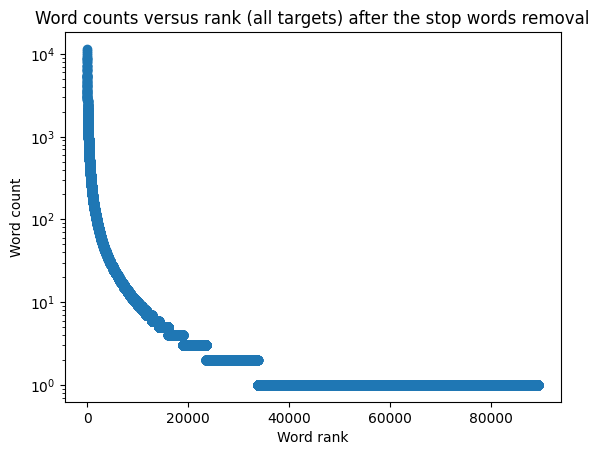

In [15]:
# Look at the frequency/rank plot, after the stop words removal
plt.title('Word counts versus rank (all targets) after the stop words removal')
plt.scatter(range(len(word_counts)), list(word_counts.values()))
plt.yscale('log')
plt.xlabel('Word rank')
plt.ylabel('Word count')
plt.show()

In [16]:
print('Word rank after the stop words removal: \n')

# Where target == -1 after the stop words removal
sent = sentiment140_df[sentiment140_df['target'] == -1]['sentence'].tolist()
vocab, word_c = get_vocabulary(sent)
word_rank = pd.DataFrame(list(word_c.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(5)
print(f'Word rank where target == -1')
print(f'{word_rank} \n')

# Where target == 1 after the stop words removal
sent = sentiment140_df[sentiment140_df['target'] == 1]['sentence'].tolist()
vocab, word_c = get_vocabulary(sent)
word_rank = pd.DataFrame(list(word_c.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(5)
print(f'Word rank where target == 1')
print(f'{word_rank} \n')

# All targets after the stop words removal
sent = sentiment140_df['sentence'].tolist()
vocab, word_c = get_vocabulary(sent)
word_rank = pd.DataFrame(list(word_c.items()), columns=['Word', 'Count']).sort_values(by='Count', ascending=False).head(5)
print(f'Word rank for all targets')
print(f'{word_rank} \n')

Word rank after the stop words removal: 

Word rank where target == -1
   Word  Count
0  work   5859
1   get   5757
2    go   5623
3  like   5112
4   day   4971 

Word rank where target == 1
   Word  Count
0  good   7714
1  love   5952
2   day   5921
3  quot   5672
4  like   4699 

Word rank for all targets
   Word  Count
0  good  11471
1   day  10892
2   get  10246
3  like   9811
4    go   9187 



We also do not want the words that appear very few times, we can set the treshold to 5 (for example)

In [17]:
rank_counts = {w:[vocabulary[w], word_counts[w]] for w in vocabulary}
rank_counts_array = np.array(list(rank_counts.values()))

print('vocabulary size: %i' % len(vocabulary))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(1000, len(vocabulary), 1000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

vocabulary size: 89392
Part of the corpus by taking the "x" most frequent words:
1000 : 0.66
2000 : 0.75
3000 : 0.80
4000 : 0.83
5000 : 0.85
6000 : 0.86
7000 : 0.88
8000 : 0.89
9000 : 0.90
10000 : 0.90
11000 : 0.91
12000 : 0.91
13000 : 0.92
14000 : 0.92
15000 : 0.93
16000 : 0.93
17000 : 0.93
18000 : 0.94
19000 : 0.94
20000 : 0.94
21000 : 0.94
22000 : 0.94
23000 : 0.95
24000 : 0.95
25000 : 0.95
26000 : 0.95
27000 : 0.95
28000 : 0.95
29000 : 0.96
30000 : 0.96
31000 : 0.96
32000 : 0.96
33000 : 0.96
34000 : 0.96
35000 : 0.96
36000 : 0.96
37000 : 0.96
38000 : 0.96
39000 : 0.97
40000 : 0.97
41000 : 0.97
42000 : 0.97
43000 : 0.97
44000 : 0.97
45000 : 0.97
46000 : 0.97
47000 : 0.97
48000 : 0.97
49000 : 0.97
50000 : 0.97
51000 : 0.97
52000 : 0.97
53000 : 0.97
54000 : 0.98
55000 : 0.98
56000 : 0.98
57000 : 0.98
58000 : 0.98
59000 : 0.98
60000 : 0.98
61000 : 0.98
62000 : 0.98
63000 : 0.98
64000 : 0.98
65000 : 0.98
66000 : 0.98
67000 : 0.98
68000 : 0.99
69000 : 0.99
70000 : 0.99
71000 : 0.99
72000

We will choose the first 3000 words, corresponding to 80% of words of the vocabulary.

In [18]:
vocabulary, word_counts = get_vocabulary(sentences, voc_threshold=3000)

In [19]:
print(vocabulary['bad'])
print(vocabulary['horrible'])
print(vocabulary['horrible'])
print(vocabulary['UNK'])

46
623
623
3000


### To go further, we can imagine to translate abreviation and spelling errors ...

## 2. Word Embedding

In [20]:
# necessary imports
from sklearn.neighbors import NearestNeighbors

Co-occurence matrix:

In [21]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary.get(word, len(vocabulary)-1) for word in sent]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1)
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = [sent_idx[j] for j in range(max(0,i-window),i)]
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j]:
            for j, ctx_idx in enumerate(l_ctx_idx):
                if distance_weighting:
                    weight = 1.0 / (len(l_ctx_idx) - j)
                else:
                    weight = 1.0
                M[idx, ctx_idx] += weight * 1.0
                M[ctx_idx, idx] += weight * 1.0
    return M

In [22]:
M = co_occurence_matrix(sentences, vocabulary, window=5, distance_weighting=False)
print(M.shape)

(3001, 3001)


In [23]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))

def print_neighbors(distance, voc, co_oc, mot, k=10):
    """
    Params:
        distance (function): distance function to use
        voc (dictionary): vocabulary
        co_oc (array): co-occurrence matrix
        mot (string): word to look for
        k (int): number of neighbors to print
    """
    inv_voc = {id: w for w, id in voc.items()}
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric=distance)
    neigh.fit(co_oc)
    dist, ind = neigh.kneighbors([co_oc[voc[mot]]])
    print("Plus proches voisins de '%s' selon la distance '%s': " % (mot, distance.__name__))
    print([[inv_voc[i] for i in s[1:]] for s in ind])

print_neighbors(euclidean, vocab, M, 'american')
print_neighbors(cosine, vocab, M, 'american')

Plus proches voisins de american selon la distance 'euclidean': 
[['rocks', 'ms', 'fave', 'space', 'michael', 'mark', 'brought', 'become', 'james']]
Plus proches voisins de american selon la distance 'cosine': 
[['thumb', 'also', 'top', 'found', 'course', 'playing', 'hehe', 'w', 'big']]


Re weighting:

In [24]:
def pmi(co_oc, positive=True):
    """
    Params:
        co_oc (array): co-occurrence matrix
        positive (bool): indicates if we use positive PMI
    Returns:    
        pmi (array): the PMI matrix
    """
    sum_vec = co_oc.sum(axis=0)
    sum_tot = sum_vec.sum()
    with np.errstate(divide='ignore'):
        pmi = np.log((co_oc * sum_tot) / (np.outer(sum_vec, sum_vec)))
    pmi[np.isinf(pmi)] = 0.0  # log(0) = 0
    if positive:
        pmi[pmi < 0] = 0.0
    return pmi

PPMI = pmi(M)

print("Avec la PPMI:")
print_neighbors(euclidean, vocab, PPMI, 'american')
print_neighbors(cosine, vocab, PPMI, 'american')

Avec la PPMI:
Plus proches voisins de american selon la distance 'euclidean': 
[['thumb', 'quot', 'good', 'know', 'like', 'lol', 'one', 'love', 'really']]
Plus proches voisins de american selon la distance 'cosine': 
[['idol', 'kris', 'heart', 'amazing', 'danny', 'awesome', 'love', 'quot', 'true']]


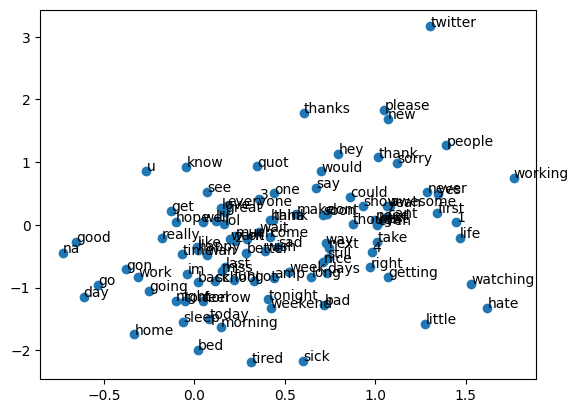

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
Emb = pca.fit_transform(PPMI)

# Let's take the most frequent words
words = sorted(word_counts.keys(), key=word_counts.get, reverse=True)[:100]

ind_words = [vocabulary[w] for w in words]
x_words = [Emb[ind,0] for ind in ind_words]
y_words = [Emb[ind,1] for ind in ind_words]

fig, ax = plt.subplots()
ax.scatter(x_words, y_words)

for i, w in enumerate(words):
    ax.annotate(w, (x_words[i], y_words[i]), (x_words[i] + 0.001, y_words[i] + 0.001))

## 3. Classification model

In [26]:
# necessary imports
import pickle

from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [27]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    representations: np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    representations = np.zeros((len(texts), embeddings.shape[1]))
    for i, sentence in enumerate(texts):
        word_vectors = []

        for word in sentence:
            if word in vocabulary.keys():
                word_idx = vocabulary[word]
                word_vectors.append(embeddings[word_idx])

        if word_vectors:
            word_vectors = np.array(word_vectors)
            representations[i] = np_func(word_vectors, axis=0)
        else:
            representations[i] = np.zeros(embeddings.shape[1])
    return representations

In [28]:
sentences = sentiment140_df['sentence'].tolist()
targets = sentiment140_df['target'].tolist()

In [29]:
train_sent, val_sent, train_labels, val_labels = train_test_split(sentences, targets, test_size=.2)

print(train_sent[:10])
print(train_labels[:10])

[['nice', 'blog', 'entry', 'tatts', 'thing', 'lovely', 'pic', 'glad', 'u', 'time', 'ti', 'urself', 'hug'], ['zebra', 'giraffe', 'thurs', 'tings'], ['need', 'male', 'friends'], ['b', 'day', 'soon', 'big', '30', 'crazy', 'super', 'excited', 'wish', 'someone', 'els', 'could', 'cleaning', 'organizing'], ['heeeeey', 'baby'], ['another', 'cloudy', 'day', 'wish', 'clouds', 'would', 'go', 'away'], ['omg', 'corinne', 'sooo', 'need', 'know', 'already', 'record', 'deal', 'patience', 'one', 'virtues', 'either'], ['still', 'able', 'sleep', 'thinking', 'maybe', 'go', 'hospital', 'soon', 'help'], ['demo', 'please'], ['ohhh', 'shizzz', 'man', 'quot', 'whats', 'dat', 'monsta', 'quot', 'focaccia', 'con', 'il', 'salame', 'quot', '5', '40', 'cant', 'dood', 'canttttt']]
[1, 1, -1, -1, -1, -1, -1, -1, 1, 1]


In [30]:
PPMI.shape

(3001, 3001)

In [31]:
# processing for SVD
U, lmbd, VT = svds(PPMI, k=500)
M = U @ np.diag(lmbd) @ VT
print(M.shape)
print(np.diag(lmbd).shape)

(3001, 3001)
(500, 500)


Classification Report:
               precision    recall  f1-score   support

          -1       0.74      0.73      0.73     20038
           1       0.73      0.75      0.74     19962

    accuracy                           0.74     40000
   macro avg       0.74      0.74      0.74     40000
weighted avg       0.74      0.74      0.74     40000



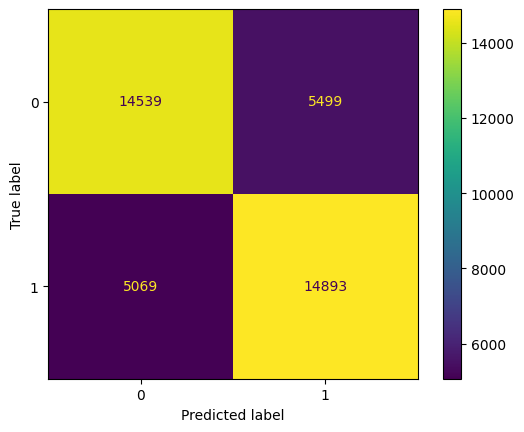

In [32]:
# Apply to SVD_PPMI Embeddings
svd_ppmi_representation_training = sentence_representations(train_sent, vocabulary, M)
svd_ppmi_representation_validation = sentence_representations(val_sent, vocabulary, M)

model_svd_ppmi = LogisticRegression(max_iter=1000)
model_svd_ppmi.fit(svd_ppmi_representation_training, train_labels)
pred_val = model_svd_ppmi.predict(svd_ppmi_representation_validation)

# Print the classification report
report = classification_report(val_labels, pred_val)
print("Classification Report:\n", report)

# Plot the confusion matrix
conf_matrix = confusion_matrix(val_labels, pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

## 4. Save the model

In [33]:
import pickle

# save
with open('source/materials/model_svd_ppmi.pkl','wb') as f:
    pickle.dump(model_svd_ppmi, f)

with open('source/materials/M.pkl','wb') as f:
    pickle.dump(M, f)

with open('source/materials/vocabulary.pkl', 'wb') as v:
    pickle.dump(vocabulary, v)